#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Начальная обработка данных:

In [4]:
def Nan_killer(x):
    x['collections_12_mths_ex_med'] = x['collections_12_mths_ex_med'].fillna(0)
    x['mths_since_last_delinq']=  x['mths_since_last_delinq'].map(lambda x: 0 if x is None else 1)
    x['revol_util'] = x['revol_util'].fillna(0)
    x['tot_coll_amt'] = x['tot_coll_amt'].fillna(0)


In [5]:
def proc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': 1, 'w': 2}) # Label encoder
    x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: 1 if x == 'INDIVIDUAL' else 2)
    x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': 1, 'w': 2}) # Label encoder
    x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: 1 if x == 'INDIVIDUAL' else 2)
    x_train = pd.get_dummies(x_train, columns = ['purpose','grade','home_ownership'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','grade','home_ownership'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [6]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [7]:
def plot_roc(model, x_test, y_test):    
    y_score = lr.fit(x_train, y_train).decision_function(x_test)
    fpr, tpr,_=roc_curve(lr.predict(x_test),y_test,drop_intermediate=False)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [8]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [9]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','mths_since_last_delinq',
                 'installment','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 21 columns):
annual_inc                    200189 non-null float64
collections_12_mths_ex_med    200145 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
mths_since_last_delinq        89621 non-null float64
installment                   200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200035 non-null float64
loan_status                   

In [10]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 21 columns):
annual_inc                    200189 non-null float64
collections_12_mths_ex_med    200189 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
mths_since_last_delinq        200189 non-null int64
installment                   200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    200189 non-null float64
loan_status                   2

In [11]:
x.nunique()

annual_inc                    16284
collections_12_mths_ex_med        7
initial_list_status               2
installment                   41347
open_acc                         58
total_acc                       105
dti                            3975
purpose                          14
grade                             7
home_ownership                    6
inq_last_6mths                    9
mths_since_last_delinq            1
installment                   41347
pub_rec                          13
revol_bal                     44045
revol_util                     1180
loan_status                       2
tot_coll_amt                   3646
loan_amnt                      1317
application_type                  2
acc_now_delinq                    6
dtype: int64

In [12]:
x_train, x_test, y_train, y_test = proc(x,y)

In [13]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 45 columns):
annual_inc                    140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null int64
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
inq_last_6mths                140132 non-null float64
mths_since_last_delinq        140132 non-null int64
installment                   140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
loan_status                   140132 non-null int64
tot_coll_amt                  140132 non-null float64
loan_amnt                     140132 non-null float64
application_type          

In [14]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 45 columns):
annual_inc                    60057 non-null float64
collections_12_mths_ex_med    60057 non-null float64
initial_list_status           60057 non-null int64
installment                   60057 non-null float64
open_acc                      60057 non-null float64
total_acc                     60057 non-null float64
dti                           60057 non-null float64
inq_last_6mths                60057 non-null float64
mths_since_last_delinq        60057 non-null int64
installment                   60057 non-null float64
pub_rec                       60057 non-null float64
revol_bal                     60057 non-null float64
revol_util                    60057 non-null float64
loan_status                   60057 non-null int64
tot_coll_amt                  60057 non-null float64
loan_amnt                     60057 non-null float64
application_type              60057 non-null 

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, max_leaf_nodes = 3000).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146678444221341

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9310920849118197

# Бинарная классификация

In [19]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','int_rate','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','mths_since_last_delinq',
                 'installment','pub_rec','revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 21 columns):
annual_inc                    200189 non-null float64
int_rate                      200189 non-null float64
collections_12_mths_ex_med    200145 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
mths_since_last_delinq        89621 non-null float64
installment                   200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    

In [20]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 21 columns):
annual_inc                    200189 non-null float64
int_rate                      200189 non-null float64
collections_12_mths_ex_med    200189 non-null float64
initial_list_status           200189 non-null object
installment                   200189 non-null float64
open_acc                      200189 non-null float64
total_acc                     200189 non-null float64
dti                           200189 non-null float64
purpose                       200189 non-null object
grade                         200189 non-null object
home_ownership                200189 non-null object
inq_last_6mths                200189 non-null float64
mths_since_last_delinq        200189 non-null int64
installment                   200189 non-null float64
pub_rec                       200189 non-null float64
revol_bal                     200189 non-null float64
revol_util                    2

In [21]:
x_train, x_test, y_train, y_test = proc(x,y)

In [22]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 45 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null int64
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
inq_last_6mths                140132 non-null float64
mths_since_last_delinq        140132 non-null int64
installment                   140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                     140132 non-null float64
application_type        

In [349]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 45 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null int64
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
inq_last_6mths                140132 non-null float64
mths_since_last_delinq        140132 non-null float64
installment                   140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                     140132 non-null float64
application_type      

## Логическая регрессия

In [23]:
from sklearn import linear_model

In [24]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


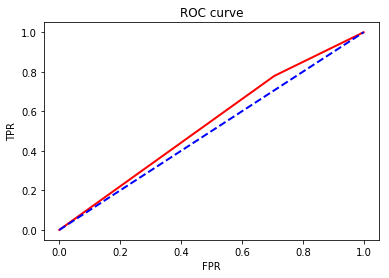

In [25]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
clf_tree = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42, min_samples_leaf = 1)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [28]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


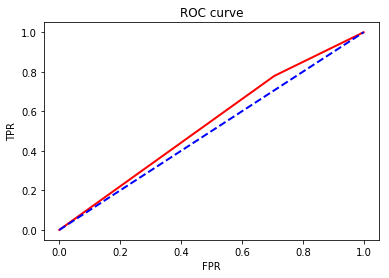

In [29]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [31]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [3,5,7,9,11],
    'min_samples_leaf': [1,3,7,11],
    'n_estimators': [100, 200,500,1000],
    'criterion' : ['gini', 'entropy']
}

In [32]:
rf =  RandomForestClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(x_train,  y_train)
grid_search.best_params_

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
best_grid = grid_search.best_estimator_
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

In [ ]:
plot_roc(lr, x_test, y_test)